In [ ]:
#getting started with setup: installing pydub


!pip install -q pydub

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
#matplotlib to plot audio as waveforms
from IPython.display import Audio
from matplotlib import pyplot as plt
from tqdm import tqdm

print(tf.__version__)
print(tfds.__version__)

2.5.0
4.0.1


In [ ]:
#musical speech dataset is being used,128 audio files of 30 secs long sample rate 22050 typically cd audio is 40k sample rate
dataset = tfds.load("gtzan_music_speech")

# Task 3: Explore the Data

In [ ]:
train = dataset["train"]
#creating a training set and a data iterator

data_iter = iter(train)

In [ ]:
example=next(data_iter)
example

{'audio': <tf.Tensor: shape=(661500,), dtype=int64, numpy=array([-2821, -3743, -4288, ...,  -717,   132,  1548])>,
 'audio/filename': <tf.Tensor: shape=(), dtype=string, numpy=b'vlobos.wav'>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}

In [ ]:
audio=example.get("audio")
label=example.get("label")

print(label.numpy())

Audio(audio, rate=22050)

0


In [ ]:
index_to_class = {0: "music", 1: "speech"}
class_to_index = {"music": 0, "speech": 1}

In [ ]:
def plot_waveform(audio):
    plt.plot(audio)
    plt.xlabel("samples")
    plt.ylabel("amplitude")
    plt.show()

# Task 4: Spectrogram

In [ ]:
def get_stft(audio, frame_length=2048, frame_step=512, fft_length=256):
    return tf.signal.stft(
        tf.cast(audio, tf.float32),
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=fft_length
    )

In [ ]:
audio_stft=get_stft(audio)
#audio_stft gives the complex values since phase component is also being included
#in order to get the amplitude component only, 
audio_spec=tf.abs(audio_stft)

In [ ]:
#takes spectogram as input and transposes it

def plot_spec(spec):
    plt.figure(figsize=(12, 4))
    plt.imshow(tf.transpose(spec), cmap="viridis")
    plt.colorbar()
    plt.show()

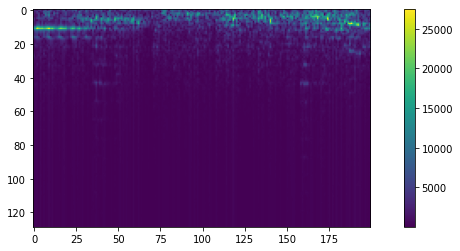

In [ ]:
plot_spec(audio_spec[:200]) 
#since some values exceed 20kHz we are gonna take the log[]

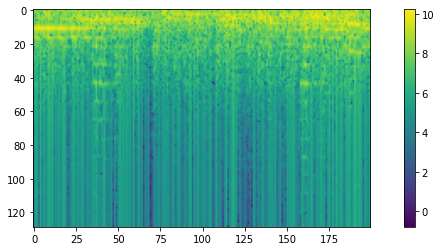

In [ ]:
audio_spec_log=tf.math.log(audio_spec)
plot_spec(audio_spec_log[:200])

In [ ]:
#encompassing all 3 options above, color represents amplitude

def get_spectrogram(audio):
    audio_stft = get_stft(audio)
    audio_spec = tf.abs(audio_stft)
    return tf.math.log(tf.transpose(audio_spec))

# Task 5: Prepare the Data

In [ ]:
sr = 22050 # samples per second
chunk_len = 5 # seconds
#we are dividing audio into 6 chunks of 5 secs each
def preprocess_example(example):
  audio=example.get("audio")
  label=example.get("label")

  x_batch, y_batch =None, None

  for i in range(0,6):
    start_sample= i*chunk_len*sr
    end_sample=(i+1)*chunk_len*sr 
    audio_chunk=audio[start_sample:end_sample]
    audio_spec=get_spectrogram(audio_chunk)
    audio_spec=tf.expand_dims(audio_spec, axis=0)
    current_label=tf.expand_dims(label,axis=0)

    x_batch=audio_spec if x_batch is None else tf.concat([x_batch,audio_spec], axis=0)
    #in the above line : if the x_batch is done it is set to audio spec, if it is not done, we will concatenate it as it is 1st iteration
    y_batch=current_label if y_batch is None else tf.concat([y_batch, current_label], axis=0)
  return x_batch, y_batch

In [ ]:
x_train, y_train=None, None

for example in tqdm(iter(train)):
  x_batch, y_batch =preprocess_example(example)

  x_train=x_batch if x_train is None else tf.concat([x_train, x_batch],axis=0)
  y_train=y_batch if y_train is None else tf.concat([y_train, y_batch], axis=0)

#iterates over all 128 files

128it [00:04, 27.31it/s]


In [ ]:
print(x_train.shape, y_train.shape)

(768, 129, 212) (768,)


In [ ]:
indices = tf.random.shuffle(list(range(0, 768)))
#assigning random indices

x_train = tf.gather(x_train, indices)
y_train = tf.gather(y_train, indices)
#shuffling x and y train with the same indices

n_val = 300

#we are creating n evaluation set
x_valid = x_train[:n_val, ...]
y_valid = y_train[:n_val, ...]

x_train = x_train[n_val:, ...]
y_train = y_train[n_val:, ...]

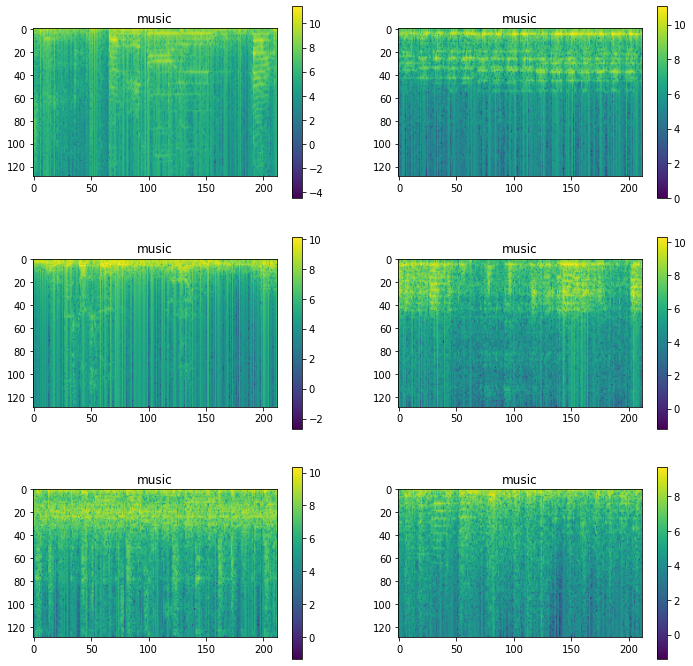

In [ ]:
plt.figure(figsize=(12, 12))

st = 0

for i in range(0, 6):
    x, y = x_train[st + i], y_train[st + i]

    plt.subplot(3, 2, i + 1)
    plt.imshow(x, cmap="viridis")
    plt.title(index_to_class[y.numpy()])
    plt.colorbar()
plt.show()

# Task 6: Create the Model

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPool2D, Flatten, Dropout, Dense

#input layer is being defined
input_=Input(shape=(129,212))
#adding a dimension to the tensor for adding channel dimensions
x=Lambda(lambda x: tf.expand_dims(x,axis=-1))(input_)

for i in range(0,4):
  num_filters=2**(5+i)
  x=Conv2D(num_filters,3) (x)
  x=BatchNormalization()(x)
  x=Activation("tanh")(x)
  x=MaxPool2D(2) (x)

  #conv layer, with layers increasing with each iteration, we have a normalizationm layer, we can replace tanh with relu, pooling reduces dimensions

x=Flatten()(x)
#flatten the output with just 1 or 2 fully connected layers
x=Dropout(0.4)(x)
x=Dense(128, activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(1,activation="sigmoid")(x)

model=tf.keras.models.Model(input_,x)


In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
    metrics=["accuracy"]
)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 129, 212)]        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 129, 212, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 210, 32)      320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 127, 210, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 127, 210, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 105, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 103, 64)       1849

# Task 7: Model Training

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, *args, **kwargs):
        super(CustomCallback, self).__init__(*args, **kwargs)
        #setting target accuracy to 95% after which it will stop
        self.target_acc = kwargs.get("target_acc") or 0.95
        self.log_epoch = kwargs.get("log_epoch") or 5

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get("loss")
        acc = logs.get("accuracy")
        val_loss = logs.get("val_loss")
        val_acc = logs.get("val_accuracy")

        if (epoch + 1) % self.log_epoch == 0:
            print(f"Epoch: {epoch:3d}, Loss: {loss:.4f}, Acc: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc >= self.target_acc:
            print("Target val accuracy achieved", val_acc)
            model.stop_training = True

In [ ]:
_=model.fit(x_train,y_train,validation_data=(x_valid,y_valid),batch_size=12, epochs=500,verbose=False, callbacks=[CustomCallback()])

Epoch:   4, Loss: 0.5684, Acc: 0.7030, Val Loss: 0.6456, Val Acc: 0.5867
Epoch:   9, Loss: 0.5636, Acc: 0.7222, Val Loss: 0.4724, Val Acc: 0.7733
Epoch:  14, Loss: 0.4366, Acc: 0.7949, Val Loss: 0.4083, Val Acc: 0.8100
Epoch:  19, Loss: 0.4005, Acc: 0.8333, Val Loss: 0.3659, Val Acc: 0.8400
Epoch:  24, Loss: 0.3950, Acc: 0.8440, Val Loss: 0.3278, Val Acc: 0.8533
Epoch:  29, Loss: 0.2934, Acc: 0.8846, Val Loss: 0.3077, Val Acc: 0.8633
Epoch:  34, Loss: 0.2521, Acc: 0.9017, Val Loss: 0.2841, Val Acc: 0.8667
Epoch:  39, Loss: 0.2248, Acc: 0.9167, Val Loss: 0.2507, Val Acc: 0.8967
Epoch:  44, Loss: 0.2424, Acc: 0.9103, Val Loss: 0.2394, Val Acc: 0.9000
Epoch:  49, Loss: 0.2183, Acc: 0.9209, Val Loss: 0.2234, Val Acc: 0.9067
Epoch:  54, Loss: 0.1485, Acc: 0.9573, Val Loss: 0.2109, Val Acc: 0.9167
Epoch:  59, Loss: 0.1444, Acc: 0.9509, Val Loss: 0.1963, Val Acc: 0.9200
Epoch:  64, Loss: 0.1435, Acc: 0.9530, Val Loss: 0.1829, Val Acc: 0.9167
Epoch:  69, Loss: 0.1353, Acc: 0.9594, Val Loss: 0.

# Task 8: Predictions

In [ ]:
example=next(data_iter)

x_test,y_test= preprocess_example(example)

preds=model.predict(x_test)
pred_classes=tf.squeeze(tf.cast(preds>0.5, tf.int8))


In [ ]:
#0 means music and 1 is speech

pred_classes

<tf.Tensor: shape=(6,), dtype=int8, numpy=array([0, 0, 0, 0, 0, 0], dtype=int8)>

In [ ]:
y_test

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0])>